In [35]:
import numpy as np
import json as js
import networkx as nx
import matplotlib.pyplot as plt

In [36]:
activation = [
  'linear',
  'relu',
  'sigmoid',
  'softmax'
]

In [37]:
class Layer:
  def __init__(self, neuron_num: int, act_function: str, weights: np.array, bias: np.array):
    self.neuron_num = neuron_num
    self.weights = weights
    self.bias = bias

    case = {
        'linear': lambda x: x,
        'relu': lambda x: np.maximum(0, x),
        'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
        'softmax': lambda x: np.exp(x) / np.sum(np.exp(x))
      }
    self.act_function = case[act_function]

  def value(self, inputData: np.array):
    self.output = self.act_function(np.dot(inputData, self.weights) + self.bias)
    return self.output


In [41]:
class FFNN:
  def __init__ (self, inputData: np.array, layers: list, model: np.array, weights: np.array):
    self.inputData = inputData
    self.layers = layers
    self.output = []
    self.model = model
    self.weights = weights
  
  def new_layer(self, layer: Layer):
    self.layers.append(layer)

  def forward(self):
    self.output = self.inputData
    for layer in self.layers:
      self.output = layer.value(self.output)
    return self.output
  
  def predictions(self):
    if(len(self.output.shape) == 1):
      self.output = [1 if x > 0.5 else 0 for x in self.output]
    else :
      self.output = [[1 if x > 0.5 else 0 for x in y] for y in self.output]
      
  

  def create_visualization(self):
    G = nx.DiGraph()
    model = self.model
    weights = self.weights
    input_size = self.model['input_size']
    layer = model['layers']
    number_of_neurons = len(weights[0][0])
    layers = 0
    bias_count = 0
    color_map = []
  
    
    
    if len(weights) == 1:
        G.add_nodes_from([f'b{i}' if i == 0 else f'input{i}' for i in range(input_size + 1)], layer=0)
        color_map.extend(['lightyellow' if 'b' in node else 'lightgreen' for node in G.nodes() if G.nodes[node]['layer'] == 0])
        G.add_nodes_from([f'output{j}' for j in range(number_of_neurons)], layer=1)
        color_map.extend(['lightgrey' for _ in range(number_of_neurons)])

        for i in range(input_size + 1):
            for j in range(number_of_neurons):
                weight = weights[0][i][j]
                G.add_edge(f'b{i}' if i == 0 else f'input{i}', f'output{j}', weight=weight)

    else:
        G.add_nodes_from([f'b{i}' if i == 0 else f'input{i}' for i in range(input_size + 1)], layer=0)
        color_map.extend(['lightyellow' if 'b' in node else 'lightgreen' for node in G.nodes() if G.nodes[node]['layer'] == 0])

        for i in range(len(weights)-1):
            layers += 1
            G.add_node(f'b{i+1}', layer=layers)
            color_map.append('lightyellow')  
            G.add_nodes_from([f'h{i+1}{j+1}' for j in range(len(weights[i][0]))], layer=layers)
            color_map.extend(['lightgreen' for _ in range(len(weights[i][0]))])


        for i in range(len(weights[-1][0])):
            layers += 1
            G.add_nodes_from([f'output{i}'], layer=layers)
        color_map.extend(['lightgrey' for _ in range(len(weights[-1][0]))])

        for i in range(len(weights)):
            for j in range(len(weights[i])):
                for k in range(len(weights[i][j])):
                    if j == 0:
                        if i == len(weights)-1:
                            G.add_edge(f'b{bias_count}', f'output{k}', weight=weights[i][j][k])
                            
                        else:
                            G.add_edge(f'b{bias_count}', f'h{i+1}{k+1}', weight=weights[i][j][k])
                    else:
                        if i == 0:
                            G.add_edge(f'input{j}', f'h{i+1}{k+1}', weight=weights[i][j][k])
                        elif i == len(weights)-1:
                            G.add_edge(f'h{i}{j}', f'output{k}', weight=weights[i][j][k])
                        else:
                            G.add_edge(f'h{i}{j}', f'h{i+1}{k+1}', weight=weights[i][j][k])
            bias_count += 1

    pos = nx.multipartite_layout(G, subset_key="layer")

    plt.figure(figsize=(14, 12))  
    edge_attribute = {(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges()}  
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color=color_map, font_size=10, edge_color='black', linewidths=1, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_attribute, font_color='blue', label_pos=0.8) 
    plt.savefig('visualization.png')
    plt.show()

[[0.31  0.    0.375]]


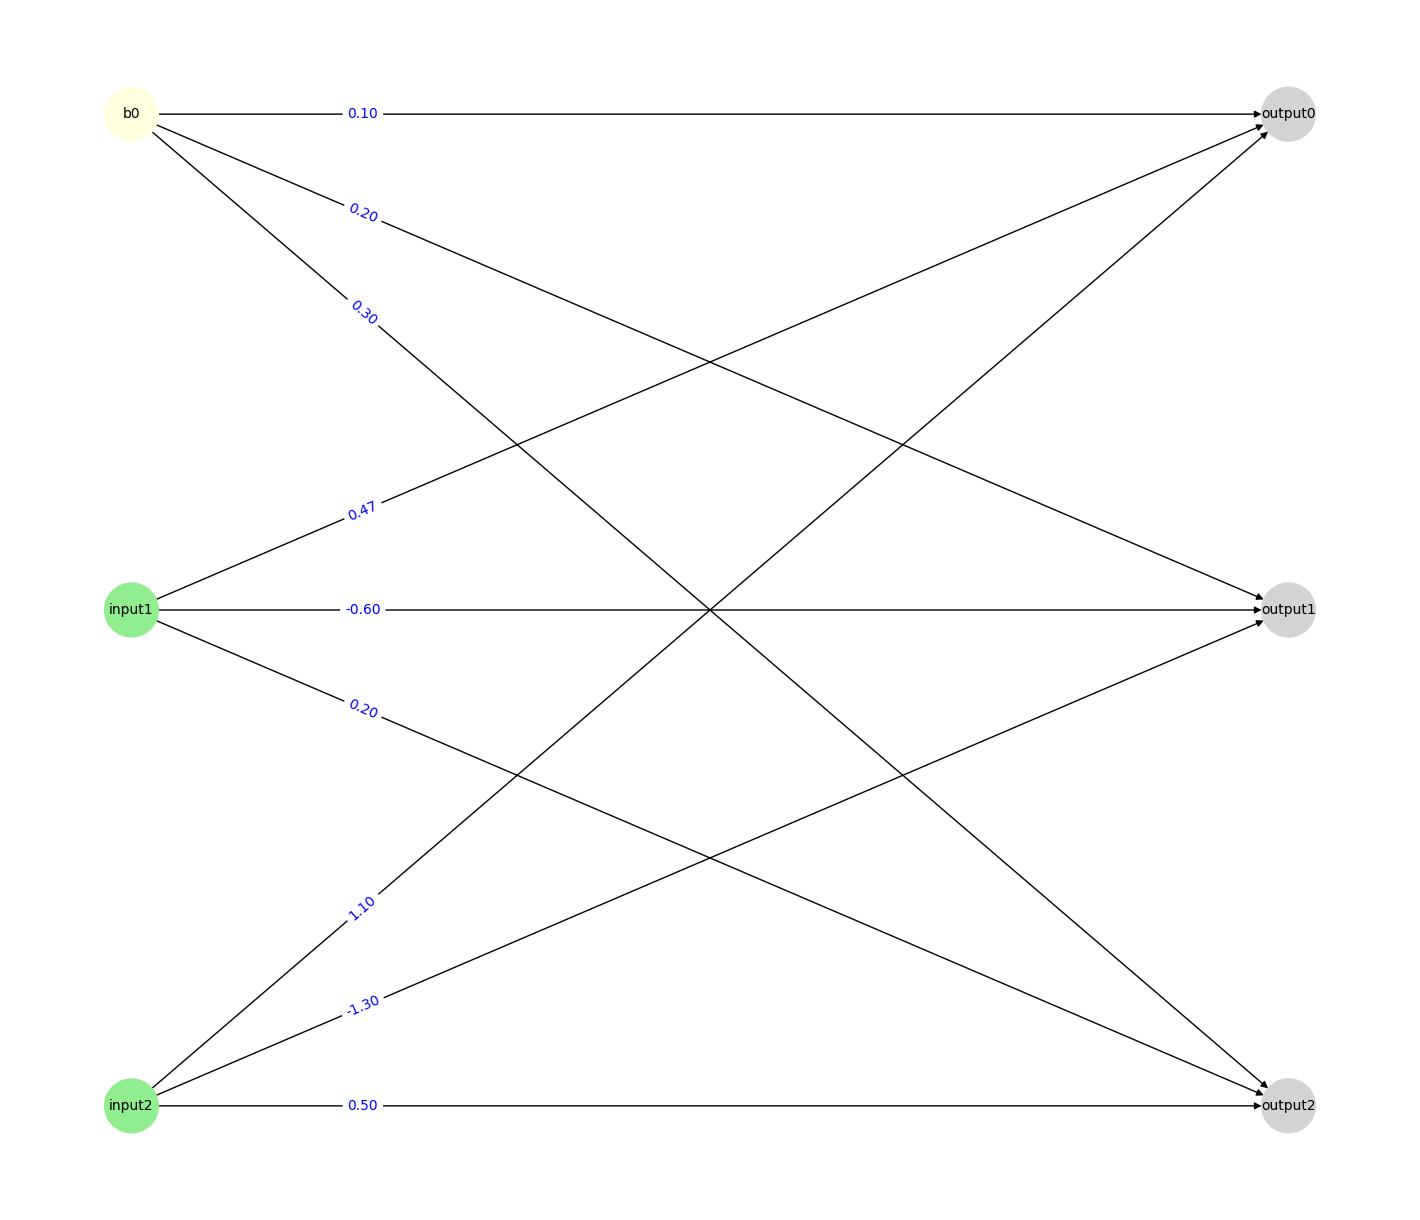

In [46]:
# read json using model
json_file = "relu.json"
with open (json_file, "r") as file:
    data = js.load(file)

# check if layers and weights are in the json file
if "case" not in data:
    print("Error: No case found in the json file")
elif "model" not in data["case"] or "weights" not in data["case"]:
    input = data["case"]["input"]
    print("weights and layer not found\nloading weights and layers from save.json")
    with open ("save.json", "r") as file:
      save = js.load(file)
    layers = save["case"]["model"]
    weights = save["case"]["weights"]
else:
  layers = data["case"]["model"]
  weights = data["case"]["weights"]
  input = data["case"]["input"]




ffnn = FFNN(np.array(input), [], layers, weights)
for i in range (len(layers["layers"])):
  layer = layers["layers"][i]
  weight = weights[i]
  new_layer = Layer(layer["number_of_neurons"], layer["activation_function"], np.array(weight[1:]), np.array(weight[0]))
  ffnn.new_layer(new_layer)
  

ffnn.forward()

new_data = {
    "case": {
        "model": 
          layers
        ,
        "weights": weights
    }
}
# write the layers and weights in the json file
with open("save.json", "w") as file:
  js.dump(new_data, file, indent=4)



print(ffnn.output)




ffnn.create_visualization()